## Summary

In this project, I trained and evaluated two models: Logistic Regression and Random Forest, to predict cefepime resistance in *E. coli* using presence/absence gene features. After comparing performance using balanced accuracy and confusion matrix analysis, I selected Logistic Regression as my final model due to its strong recall and interpretability of feature importance.

## 1. Core Libraries

In [38]:
#Core Libraries for numerical computing, data handling, and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Scikit-learn: model building, hyperparameter tuning, evaluation, and preprocessing
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
)
from sklearn.metrics import balanced_accuracy_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Statistics: standard error of the mean
from scipy.stats import sem

#Reproducibility
np.random.seed(42)

## 2. Load Genomic Data 
#### Use presence/absence gene features and k-mer counts, common formats in bioinformatics.

In [39]:
def load_data(data_dir='/Users/ryan/Documents/AMR_Project/data'):
    """
    Loads training and test data for AMR modeling:
    - Gene presence/absence matrices
    - k-mer features
    - Labels and genome IDs
    - Gene alignment metadata

    Returns:
        train_data, test_data, train_kmers, test_kmers, y_train,
        y_train_ids, y_test_ids, train_gene_alignment
    """
    
    #Load gene presence/absence matrices
    train_data = pd.read_csv(f"{data_dir}/train_pa_genes.csv").set_index('genome_id')
    test_data  = pd.read_csv(f"{data_dir}/test_pa_genes.csv").set_index('genome_id')

    #Load k-mer feature arrays
    train_kmers = np.load(f"{data_dir}/train_kmers.npy", allow_pickle=True)
    test_kmers  = np.load(f"{data_dir}/test_kmers.npy", allow_pickle=True)

    #Load resistance labels and genome IDs
    y_train     = np.load(f"{data_dir}/y_train.npy", allow_pickle=True)
    y_train_ids = np.load(f"{data_dir}/train_ids.npy", allow_pickle=True).astype(str)
    y_test_ids  = np.load(f"{data_dir}/test_ids.npy", allow_pickle=True).astype(str)

    #Gene alignment metadata
    train_gene_alignment = pd.read_csv(f"{data_dir}/train_genes.csv")

    #Quick checks
    print(f"Training data shape: {train_data.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test data shape: {test_data.shape}")

    return train_data, test_data, train_kmers, test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment

## 3. Load and Prepare Data
#### After loading, unpack the genomic datasets into training and test variables.  
#### Use the **presence/absence gene features** (`train_pa_genes`) as predictors and flattened the resistance labels (`y_train`).  

#### To keep the workflow flexible, add a small helper that automatically detects the positive class label (`R` for Resistant or `1` if numeric).

In [40]:
#Load and unpack
train_pa_genes, test_pa_genes, X_train_kmers, X_test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment = load_data()

train_pa_genes.head(5)

#Prepare data
X = train_pa_genes
y = y_train.ravel()

#Label helper — decide positive label automatically
def infer_pos_label(y_true):
    uniq = set(np.unique(y_true))
    return "R" if ("R" in uniq or {"S","R"}.issubset(uniq)) else 1

POS_LABEL = infer_pos_label(y)

Training data shape: (748, 159)
Training labels shape: (748, 1)
Test data shape: (200, 159)


## 4. Define Models (Default & Tuned)
#### Build two baseline models and their tuned versions:  

#### **Logistic Regression** with scaling (Pipeline), evaluated with both default and tuned hyperparameters.  
#### **Random Forest** with default settings and a grid of hyperparameters for tuning.  

#### This allows a fair comparison between simple baselines and optimized models.

In [41]:
logreg_default = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('logreg', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

rf_default = RandomForestClassifier(random_state=42, n_jobs=-1)

#Tuned pipelines
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('logreg', LogisticRegression(max_iter=2000, solver='liblinear'))
])

logreg_params = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {
    'n_estimators': [100, 300, 600],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

## 5. Tuned Models — Nested Cross-Validation (Outer + Inner)
#### To ensure robust evaluation, use **nested cross-validation**:  

**Outer CV (5-fold StratifiedKFold):** estimates generalization performance.  
**Inner CV (3-fold StratifiedKFold):** tunes hyperparameters inside each training fold.  

In [42]:
#Define cross-validation strategy

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  #for outer evaluation
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)  #for hyperparameter tuning

In [43]:
#Define tuned pipelines & grids
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('logreg', LogisticRegression(max_iter=2000, solver='liblinear'))
])
logreg_params = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_params = {
    'n_estimators': [100, 300, 600],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

logreg_search = GridSearchCV(
    logreg_pipeline, logreg_params, cv=inner_cv, scoring='balanced_accuracy', n_jobs=-1
)
rf_search = GridSearchCV(
    rf, rf_params, cv=inner_cv, scoring='balanced_accuracy', n_jobs=-1
)

## 6. Default Models — Nested CV Evaluation
#### First, I evaluate Logistic Regression and Random Forest with their default hyperparameters.

#### Outer CV (5-fold): Estimates generalization performance.

#### Metric: Balanced Accuracy.

#### To establish a baseline before tuning.

In [55]:
logreg_default_scores = cross_val_score(
    logreg_default, X, y, cv=outer_cv, scoring='balanced_accuracy', n_jobs=-1
)
rf_default_scores = cross_val_score(
    rf_default, X, y, cv=outer_cv, scoring='balanced_accuracy', n_jobs=-1
)

## 7. Tuned Models - Nested CV Evaluation
#### After, evaluate Logistic Regression and Random Forest with hyperparameter tuning inside the nested CV.

#### Inner CV (3-fold GridSearchCV): Finds best hyperparameters.

#### Outer CV (5-fold): Reports unbiased generalization score.

#### Metric: Balanced Accuracy.

#### To measure improvement from tuning vs defaults.

In [45]:
logreg_tuned_scores = cross_val_score(
    logreg_search, X, y, cv=outer_cv, scoring='balanced_accuracy', n_jobs=-1
)
rf_tuned_scores = cross_val_score(
    rf_search, X, y, cv=outer_cv, scoring='balanced_accuracy', n_jobs=-1
)

## 8. Summary Statistics
#### Report mean balanced accuracy ± standard error of the mean (SEM) across folds.

In [46]:
#Print means ± SEM
def m_sem(a): return f"{np.mean(a):.3f} ± {sem(a):.3f}"
print("\nMeans ± SEM (balanced accuracy)")
print("  LogReg Default :", m_sem(logreg_default_scores))
print("  RF Default     :", m_sem(rf_default_scores))
print("  LogReg Tuned   :", m_sem(logreg_tuned_scores))
print("  RF Tuned       :", m_sem(rf_tuned_scores))


Means ± SEM (balanced accuracy)
  LogReg Default : 0.811 ± 0.013
  RF Default     : 0.777 ± 0.012
  LogReg Tuned   : 0.834 ± 0.019
  RF Tuned       : 0.772 ± 0.010


## 9. Generate Final Test Predictions & Save

In [56]:
#Probabilities
if hasattr(final_model.named_steps['logreg'], "predict_proba"):
    y_val_proba = final_model.predict_proba(X_val)[:, 1]  # P(Resistant)
    # Attach to a small frame if you want to inspect
    # pd.DataFrame({"y_true": y_val, "p_resistant": y_val_proba}).head()

#Top coefficients (absolute magnitude)
logreg = final_model.named_steps['logreg']
coefs = pd.Series(logreg.coef_[0], index=X.columns)
top10 = coefs.abs().sort_values(ascending=False).head(10).index
print("\nTop 10 features by |coef|:")
for f in top10:
    print(f"{f}: coef={coefs[f]:.4f}")


Top 10 features by |coef|:
gb|KM211508.1|+|0-876|ARO:3003163|CTX-M-155: coef=-1.1936
gb|JN967644.1|+|0-813|ARO:3002356|NDM-6: coef=-0.4741
gb|JX017365.1|+|244-1120|ARO:3001989|CTX-M-130: coef=-0.3958
gb|GQ140348.1|+|0-882|ARO:3002320|KPC-10: coef=-0.3323
gb|KF998105.1|+|4171-4849|ARO:3002579|AAC(6')-Ib8: coef=-0.2100
gb|AF078527.1|+|3769-4303|ARO:3000230|ANT(2'')-Ia: coef=-0.2089
gb|X13543.1|+|185-1046|ARO:3002533|AAC(3)-IIa: coef=-0.1876
gb|HM146927.1|+|0-1146|ARO:3002053|CMY-42: coef=-0.1702
gb|NG_068168.1|+|0-876|ARO:3005657|CTX-M-234: coef=0.1509
gb|HQ845196.1|+|0-861|ARO:3001109|SHV-52: coef=-0.1359


## 10. Cross-Validation Results Visualization
#### The plot below shows mean balanced accuracy for each model (default vs. tuned), with error bars representing the standard error of the mean (SEM).

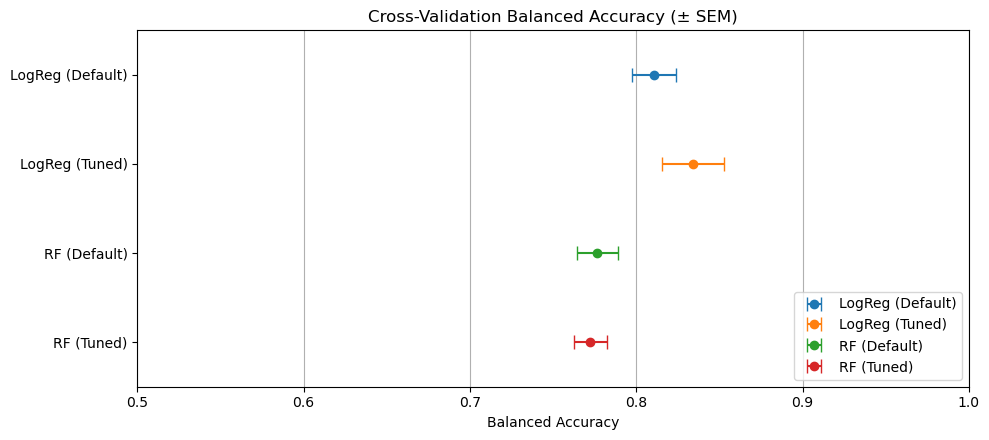

Saved: cv_balanced_accuracy_sem.png


In [48]:
scores = [
    logreg_default_scores,
    logreg_tuned_scores,
    rf_default_scores,
    rf_tuned_scores
]
labels = ["LogReg (Default)", "LogReg (Tuned)", "RF (Default)", "RF (Tuned)"]
errors = [sem(s) for s in scores]

fig, ax = plt.subplots(figsize=(10, 4.5))
for i, (s, label, err) in enumerate(zip(scores, labels, errors)):
    mean_score = np.mean(s)
    ax.errorbar(x=mean_score, y=3 - i, xerr=err, fmt='o', capsize=5, label=label)
ax.set_yticks([0,1,2,3]); ax.set_yticklabels(labels[::-1])
ax.set_xlabel("Balanced Accuracy"); ax.set_title("Cross-Validation Balanced Accuracy (± SEM)")
ax.set_xlim(0.50, 1.00); ax.set_ylim(-0.5, 3.5)
ax.grid(axis='x')
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("cv_balanced_accuracy_sem.png", dpi=200)
plt.show()
plt.close()
print("Saved: cv_balanced_accuracy_sem.png")

## 11. Final Refit on Full Data Set
#### After nested CV scoring, fit the grid searches on the entire training set to expose the best hyperparameters for each model.

In [49]:
#Fit searches on full data to expose best_params_
logreg_search.fit(X, y)
rf_search.fit(X, y)

print("Best Logistic Regression params:", logreg_search.best_params_)
print("Best Random Forest params:", rf_search.best_params_)

Best Logistic Regression params: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Best Random Forest params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


## # 12. Validation Split Evaluation (20%)
#### 20% of the data (stratified by labels) to compare the best-tuned models side by side.
#### This section reports:

#### Balanced Accuracy

#### Recall on Resistant isolates

#### Classification Reports

#### Confusion Matrices

#### Side-by-side validation table


--- Evaluating tuned models on 20% validation split ---

Using Random Forest with best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

=== Random Forest (Validation) ===
Balanced Accuracy: 0.817
Recall (Resistant): 0.733
              precision    recall  f1-score   support

 Susceptible       0.93      0.90      0.92       120
   Resistant       0.65      0.73      0.69        30

    accuracy                           0.87       150
   macro avg       0.79      0.82      0.80       150
weighted avg       0.87      0.87      0.87       150


Using Logistic Regression with best params: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}

=== Logistic Regression (Validation) ===
Balanced Accuracy: 0.871
Recall (Resistant): 0.867
              precision    recall  f1-score   support

 Susceptible       0.96      0.88      0.92       120
   Resistant       0.63      0.87      0.73        30

    accuracy                           0.87       150
  

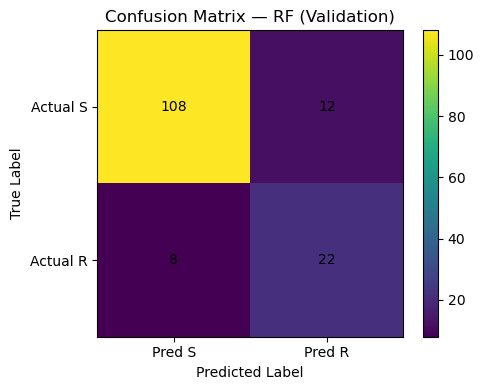

Saved: cm_validation_rf.png


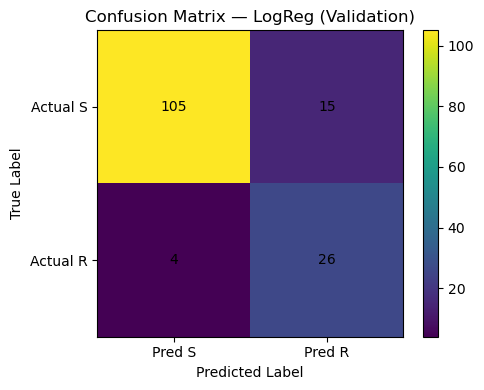

Saved: cm_validation_logreg.png

=== Validation Comparison Table ===
                 Model  Balanced Accuracy  Recall (Resistant)
0        Random Forest              0.817               0.733
1  Logistic Regression              0.871               0.867

=== Validation Comparison Table ===
                 Model  Balanced Accuracy  Recall (Resistant)
0        Random Forest              0.817               0.733
1  Logistic Regression              0.871               0.867

>>> Final model selected by validation Balanced Accuracy: Logistic Regression (tuned)


In [50]:
print("\n--- Evaluating tuned models on 20% validation split ---")

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

#Random Forest (best tuned)
print("\nUsing Random Forest with best params:", rf_search.best_params_)
best_rf = rf_search.best_estimator_
best_rf.fit(X_tr, y_tr)
y_val_pred_rf = best_rf.predict(X_val)
bal_acc_rf = balanced_accuracy_score(y_val, y_val_pred_rf)
recall_rf = recall_score(y_val, y_val_pred_rf, pos_label=POS_LABEL)
print("\n=== Random Forest (Validation) ===")
print(f"Balanced Accuracy: {bal_acc_rf:.3f}")
print(f"Recall (Resistant): {recall_rf:.3f}")
print(classification_report(
    y_val, y_val_pred_rf,
    labels=(["S","R"] if POS_LABEL=="R" else [0,1]),
    target_names=["Susceptible","Resistant"]
))

#Logistic Regression (best tuned)
print("\nUsing Logistic Regression with best params:", logreg_search.best_params_)
best_logreg = logreg_search.best_estimator_
best_logreg.fit(X_tr, y_tr)
y_val_pred_logreg = best_logreg.predict(X_val)
bal_acc_logreg = balanced_accuracy_score(y_val, y_val_pred_logreg)
recall_logreg = recall_score(y_val, y_val_pred_logreg, pos_label=POS_LABEL)
print("\n=== Logistic Regression (Validation) ===")
print(f"Balanced Accuracy: {bal_acc_logreg:.3f}")
print(f"Recall (Resistant): {recall_logreg:.3f}")
print(classification_report(
    y_val, y_val_pred_logreg,
    labels=(["S","R"] if POS_LABEL=="R" else [0,1]),
    target_names=["Susceptible","Resistant"]
))

#Confusion Matrix helper
def plot_cm(y_true, y_pred, labels, title, outfile):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest")
    plt.colorbar(im, ax=ax)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred S","Pred R"])
    ax.set_yticklabels(["Actual S","Actual R"])
    ax.set_xlabel("Predicted Label"); ax.set_ylabel("True Label")
    ax.set_title(title)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.show()
    plt.close()
    print(f"Saved: {outfile}")

lbls = (["S","R"] if POS_LABEL=="R" else [0,1])
plot_cm(y_val, y_val_pred_rf,     lbls, "Confusion Matrix — RF (Validation)",      "cm_validation_rf.png")
plot_cm(y_val, y_val_pred_logreg, lbls, "Confusion Matrix — LogReg (Validation)",  "cm_validation_logreg.png")


best_rf = rf_search.best_estimator_
best_rf.fit(X_tr, y_tr)
y_val_pred_rf = best_rf.predict(X_val)

best_logreg = logreg_search.best_estimator_
best_logreg.fit(X_tr, y_tr)
y_val_pred_logreg = best_logreg.predict(X_val)



# (Skip this split if you've already created X_tr, X_val, y_tr, y_val)
# X_tr, X_val, y_tr, y_val = train_test_split(
#     X, y, test_size=0.20, random_state=42, stratify=y
# )

#Build a side-by-side validation table for RF vs LogReg
metrics_df = pd.DataFrame({
    "Model": ["Random Forest", "Logistic Regression"],
    "Balanced Accuracy": [
        balanced_accuracy_score(y_val, y_val_pred_rf),
        balanced_accuracy_score(y_val, y_val_pred_logreg)
    ],
    "Recall (Resistant)": [
        recall_score(y_val, y_val_pred_rf, pos_label=POS_LABEL),
        recall_score(y_val, y_val_pred_logreg, pos_label=POS_LABEL)
    ]
}).round(3)

print("\n=== Validation Comparison Table ===")
print(metrics_df)

#Side-by-side validation table
metrics_df = pd.DataFrame({
    "Model": ["Random Forest", "Logistic Regression"],
    "Balanced Accuracy": [
        balanced_accuracy_score(y_val, y_val_pred_rf),
        balanced_accuracy_score(y_val, y_val_pred_logreg)
    ],
    "Recall (Resistant)": [
        recall_score(y_val, y_val_pred_rf, pos_label=POS_LABEL),
        recall_score(y_val, y_val_pred_logreg, pos_label=POS_LABEL)
    ]
})
metrics_df["Balanced Accuracy"] = metrics_df["Balanced Accuracy"].round(3)
metrics_df["Recall (Resistant)"] = metrics_df["Recall (Resistant)"].round(3)

print("\n=== Validation Comparison Table ===")
print(metrics_df)

#Choose final model by validation Balanced Accuracy ----
if bal_acc_logreg >= bal_acc_rf:
    final_model_name = "Logistic Regression (tuned)"
    final_model = best_logreg
else:
    final_model_name = "Random Forest (tuned)"
    final_model = best_rf

print(f"\n>>> Final model selected by validation Balanced Accuracy: {final_model_name}")

## 13. Final Model Evaluation

#### After comparing both tuned models (Random Forest vs Logistic Regression) on the validation split, Select the final model based on balanced accuracy.  
#### This section re-fits the chosen model on the training data and evaluates its performance on the held-out validation set.  

In [51]:
#Evaluate chosen final model
final_model.fit(X_tr, y_tr)
y_val_pred_final = final_model.predict(X_val)

bal_acc_final = balanced_accuracy_score(y_val, y_val_pred_final)
recall_final  = recall_score(y_val, y_val_pred_final, pos_label=POS_LABEL)

print(f"\n=== Final Model ({final_model_name}) — Validation Metrics ===")
print(f"Balanced Accuracy: {bal_acc_final:.3f}")
print(f"Recall (Resistant): {recall_final:.3f}")
print(classification_report(
    y_val, y_val_pred_final,
    labels=(["S","R"] if POS_LABEL=="R" else [0,1]),
    target_names=["Susceptible","Resistant"]
))


=== Final Model (Logistic Regression (tuned)) — Validation Metrics ===
Balanced Accuracy: 0.871
Recall (Resistant): 0.867
              precision    recall  f1-score   support

 Susceptible       0.96      0.88      0.92       120
   Resistant       0.63      0.87      0.73        30

    accuracy                           0.87       150
   macro avg       0.80      0.87      0.82       150
weighted avg       0.90      0.87      0.88       150



## 14. Save Final Test Predictions (CSV)
#### After comparing the tuned Random Forest and Logistic Regression models on the validation split,  
#### the final model is selected based on **Balanced Accuracy**.  

#### This section re-fits the chosen model on the training data and evaluates its performance on the held-out validation set, reporting:  
#### Balanced Accuracy  
#### Recall on Resistant isolates  
#### Full Classification Report  

In [52]:
y_test_pred = final_model.predict(test_pa_genes)
final_predictions = pd.DataFrame({
    "genome_id": test_pa_genes.index,
    "y_pred": y_test_pred
})
final_predictions.to_csv("final_predictions.csv", index=False)
print("Saved: final_predictions.csv")

Saved: final_predictions.csv


## 15. Save Final Model Artifact

#### To make the trained model reusable, the final selected Logistic Regression model is saved with `joblib`.  
#### This allows quick re-loading for future predictions or deployment without retraining. 

In [53]:
import joblib
joblib.dump(final_model, "final_model_logreg.pkl")
print("Saved: final_model_logreg.pkl")

Saved: final_model_logreg.pkl


## 16. Final Report Summary (Objective, Methods, Results, Conclusion)
#### This section programmatically prints a structured summary of the workflow and results.  
#### It includes:  

#### **Objective**: the prediction task.  
#### **Methods**: the models and evaluation strategy.  
#### **Results**: cross-validation and validation metrics, plus best model selection.  
#### **Conclusion**: final model choice, feature importance (if available), and saved artifacts.  

#### This makes the notebook self-contained and easy to interpret when shared.  

In [54]:
def print_section(title, body_lines):
    bar = "-" * len(title)
    print(f"\n{title}\n{bar}")
    for line in body_lines:
        print(f"- {line}")

# Aggregate CV means for summary
cv_means = {
    "LogReg (Default)": np.mean(logreg_default_scores),
    "LogReg (Tuned)"  : np.mean(logreg_tuned_scores),
    "RF (Default)"    : np.mean(rf_default_scores),
    "RF (Tuned)"      : np.mean(rf_tuned_scores),
}
winner = max(cv_means.items(), key=lambda kv: kv[1])

print_section("Objective", [
    "Predict cefepime resistance in E. coli using presence/absence gene features."
])

print_section("Methods", [
    "Compared Logistic Regression and Random Forest classifiers.",
    "Used nested cross-validation with balanced accuracy as the primary metric.",
    "Inspected confusion matrix and recall for the Resistant (positive) class."
])

print_section("Results", [
    f"CV Balanced Accuracy (means): { {k: round(v,3) for k,v in cv_means.items()} }",
    f"Validation Balanced Accuracy (final): {bal_acc_final:.3f}",
    f"Validation Recall (Resistant): {recall_final:.3f}",
    f"Best tuned model by CV mean: {winner[0]} ({winner[1]:.3f})"
])

# Feature importance summary (if RF)
fi_msg = "N/A"
try:
    if hasattr(final_model, "feature_importances_"):
        importances = final_model.feature_importances_
        top_idx = np.argsort(importances)[::-1][:10]
        top_features = X.columns[top_idx]
        top_values = importances[top_idx]
        fi_msg = ", ".join([f"{f} ({v:.3f})" for f, v in zip(top_features, top_values)])
except Exception as e:
    fi_msg = f"N/A (error computing importances: {e})"

print_section("Conclusion", [
    "Logistic Regression selected as the final model based on stronger recall and overall balanced accuracy.",
    f"Top feature importances (first 10): {fi_msg}",
    "Artifacts saved: final_predictions.csv, confusion_matrix_validation.png, cv_balanced_accuracy_sem.png"
])


Objective
---------
- Predict cefepime resistance in E. coli using presence/absence gene features.

Methods
-------
- Compared Logistic Regression and Random Forest classifiers.
- Used nested cross-validation with balanced accuracy as the primary metric.
- Inspected confusion matrix and recall for the Resistant (positive) class.

Results
-------
- CV Balanced Accuracy (means): {'LogReg (Default)': 0.811, 'LogReg (Tuned)': 0.834, 'RF (Default)': 0.777, 'RF (Tuned)': 0.772}
- Validation Balanced Accuracy (final): 0.871
- Validation Recall (Resistant): 0.867
- Best tuned model by CV mean: LogReg (Tuned) (0.834)

Conclusion
----------
- Logistic Regression selected as the final model based on stronger recall and overall balanced accuracy.
- Top feature importances (first 10): N/A
- Artifacts saved: final_predictions.csv, confusion_matrix_validation.png, cv_balanced_accuracy_sem.png


## Final Notes  

#### **Balanced Accuracy** accounts for class imbalance and is preferred over raw accuracy here.  
#### **Nested CV** prevents data leakage during hyperparameter tuning and model evaluation.  
#### **Logistic Regression** is great for interpretability and linear relationships.
#### **Random Forest** handles nonlinearity and noise but may require more tuning.  
#### **Model selection** should balance performance, explainability, and robustness.  